In [14]:
import os
import sys
import pickle
import random
from datetime import datetime, date

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.preprocessing import minmax_scale, scale, StandardScaler
from statsmodels.tsa.stattools import adfuller


sys.path.append(f"{os.getcwd()}/../")

from src.data.processing.utils import CleanUp, SNOWBALL_STEMMER
from src.database.models import RawHashtagComments, UserLocation

sns.set(style="darkgrid")
%matplotlib inline

steps = 5

normalizar = CleanUp(remove_stopwords=True)

In [2]:
df_covid = pd.read_csv("https://raw.githubusercontent.com/rdenadai/covid19statistics/master/data/covid-19/brazil/cases-brazil-cities-time-2020-06-14.csv")

covid_data = df_covid[["date", "newCases", "newDeaths"]].copy()
covid_data["date"] = pd.to_datetime(covid_data["date"], format='%Y-%m-%d')
covid_data = covid_data.groupby([covid_data["date"].dt.date]).sum().reset_index()

# print(df_covid.columns)

In [3]:
hashtags_ = pd.DataFrame(list(RawHashtagComments.select().dicts()))
hashtags_ = hashtags_.drop(["hash"], axis=1)
users_ = pd.DataFrame(list(UserLocation.select().dicts()))

In [4]:
# print(hashtags_.columns)
# print(users_.columns)

## Informações da base de dados

In [5]:
print(f"Qtde. de Comentários            : {len(hashtags_)}")
print(f"Qtde. de Comentários positivos  : {len(hashtags_[hashtags_['classify'] == 'positivo'])}")
print(f"Qtde. de Comentários negativos  : {len(hashtags_[hashtags_['classify'] == 'negativo'])}")
print("-" * 40)
print(f"Qtde. de Usuários geolocalizados: {len(users_)}")
print(f"Qtde. de Usuários em SP         : {len(users_[users_['state'] == 'SP'])}")
print(f"Qtde. de Usuários em RJ         : {len(users_[users_['state'] == 'RJ'])}")

Qtde. de Comentários            : 244456
Qtde. de Comentários positivos  : 85785
Qtde. de Comentários negativos  : 158671
----------------------------------------
Qtde. de Usuários geolocalizados: 60148
Qtde. de Usuários em SP         : 11883
Qtde. de Usuários em RJ         : 12479


Exemplos de comentários com suas classificações:

In [6]:
for idx, row in hashtags_.sample(n=5).iterrows():
    print(f"{row.classify}|{row.comment}")

positivo|Vim passar dias na casa da minha avo dai ontem falta de ar e hoje dor de barriga hm
negativo|começo do video me deu uma falta de ar do caralho, achei q ele ia cair, ai terminei o video rachando o bico kkkkkkkkkkk vtnc Citar Tweet Rolê Aleatório @rolealeatorio  · 3 h rapaiz
negativo|Só de pensar em fumar um rosh já da falta de ar
positivo|Em resposta a  @antesdadesgra Comecei a trabalhar desde cedo para ajudar minha familia mas com o corona perdi o emprego então to trabalhando na Hotmart e estou tendo um retorno bom em menos de 1 semana, quem Puder me ajudar dando  RT e FAV no meu fixado vai me ajudar mt, dê uma olhada no post vc vai gostar
positivo|Dor de cabeça, febre, cansaço e tosse seca hmmmmm


## Nuvens de palavras

Nuvem de palavras de todos os comentários na base de dados.

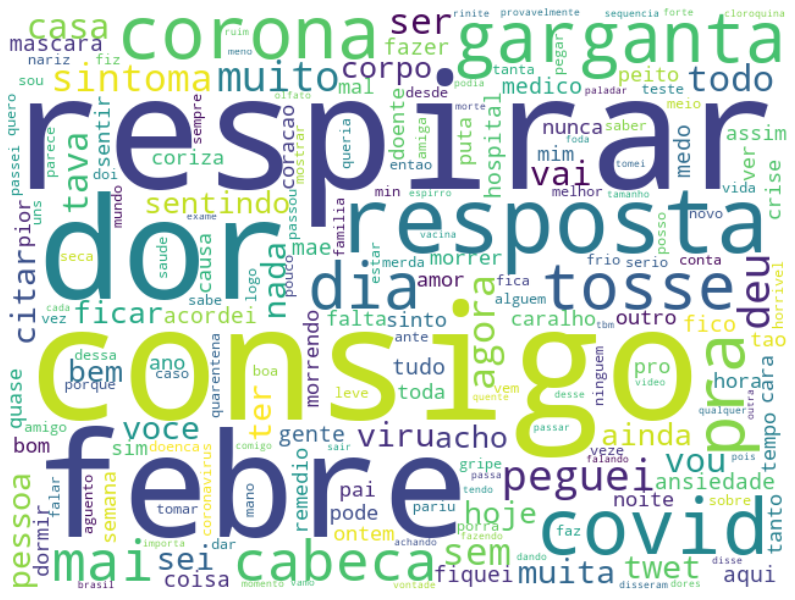

In [23]:
wordcloud = WordCloud(
    width=640, height=480,
    background_color="white", collocations=False,
    stopwords=["nao", "estou", "duvida"]
).generate(" ".join([normalizar.fit(frase) for frase in hashtags_["clean_comment"].tolist()]))

plt.figure(figsize=(14, 12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Nuvens de palavras apenas de comentários classificados como positivos.

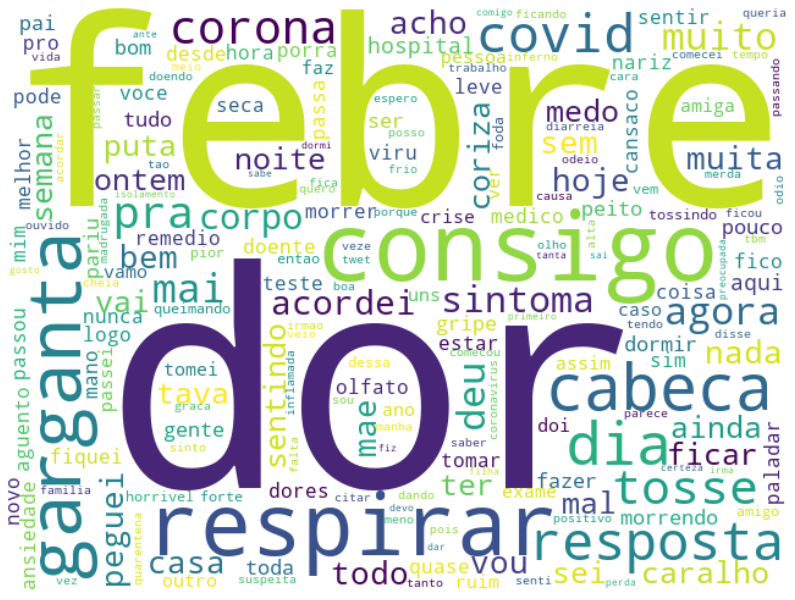

In [24]:
wordcloud = WordCloud(
    width=640, height=480,
    background_color="white", collocations=False,
    stopwords=["nao", "estou", "duvida"]
).generate(" ".join([normalizar.fit(frase) for frase in hashtags_[hashtags_['classify'] == 'positivo']["clean_comment"].tolist()]))

plt.figure(figsize=(14, 12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## Visualizações dos dados

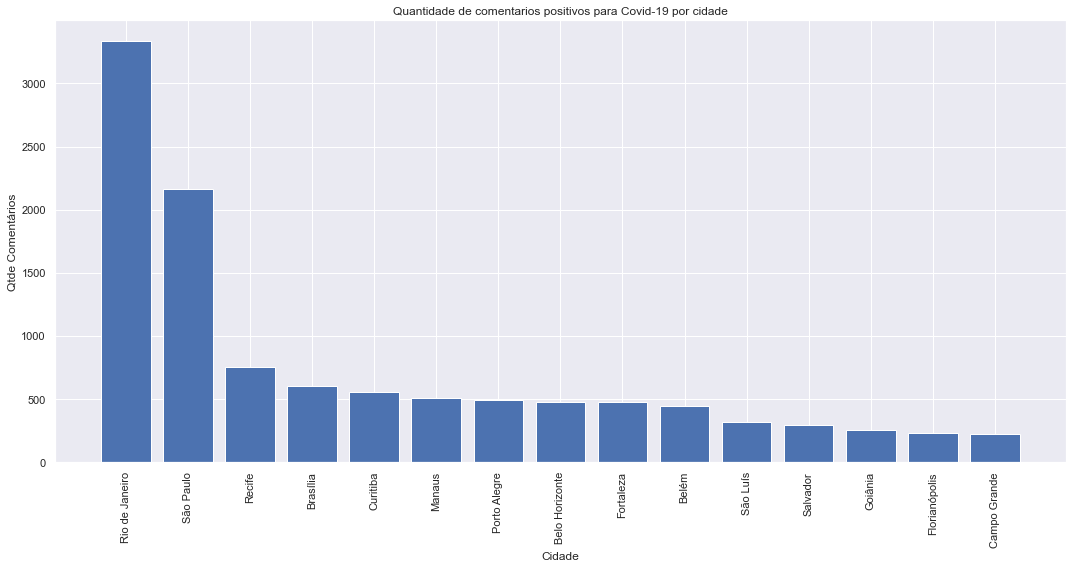

In [7]:
# Pega todos os usuarios do estado de sao paulo
# sp = users_[users_['state'] == 'SP'].copy()
# Sem filtrar por estado...
usr = users_.copy()
usr['count'] = 1
# filtra estes usuarios com comentarios identificados como positivo
nusr = hashtags_[(hashtags_['username'].isin(usr['username'])) & (hashtags_['classify'] == 'positivo')]['username']
# Tendo os usuarios com comentarios positivos filtra novamente
usr = usr[usr['username'].isin(nusr)]
# Agrupa e soma a quantidade por cidade do estado de sao paulo
usr = usr.drop_duplicates("username").groupby(['city']).sum().reset_index()[['city', 'count']].sort_values(by=['count'], ascending=False)

# Grafico
plt.figure(figsize=(15, 8))
plt.title("Quantidade de comentarios positivos para Covid-19 por cidade")
plt.bar(usr['city'][:15], usr['count'][:15])
plt.xticks(rotation=90)
plt.xlabel("Cidade")
plt.ylabel("Qtde Comentários")
plt.tight_layout()
plt.show()

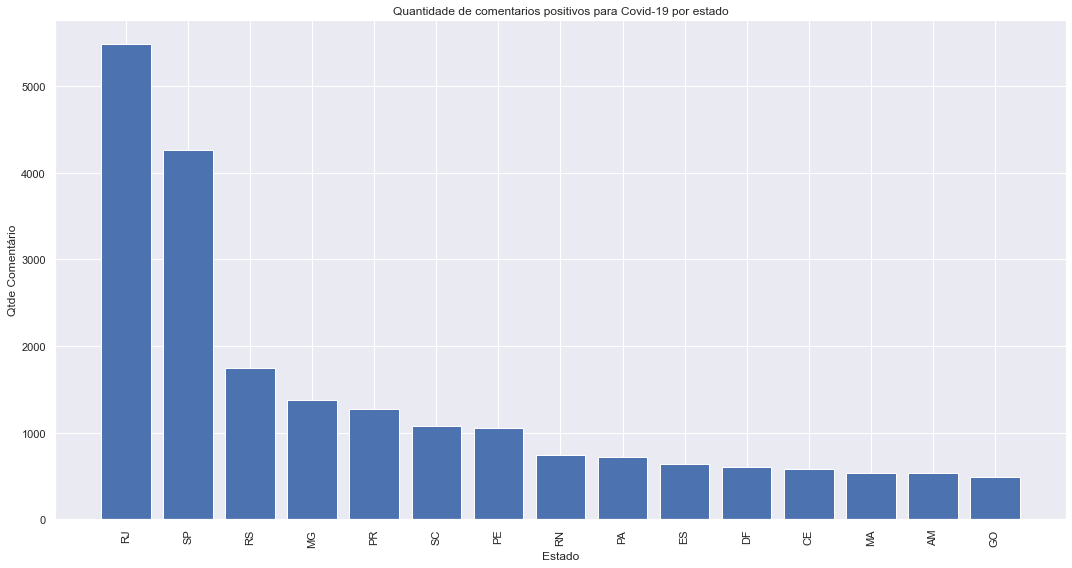

In [8]:
# Pega todos os usuarios do estado de sao paulo
# sp = users_[users_['state'] == 'SP'].copy()
# Sem filtrar por estado...
usr = users_.copy()
usr['count'] = 1
# filtra estes usuarios com comentarios identificados como positivo
nusr = hashtags_[(hashtags_['username'].isin(usr['username'])) & (hashtags_['classify'] == 'positivo')]['username']
# Tendo os usuarios com comentarios positivos filtra novamente
usr = usr[usr['username'].isin(nusr)]
# Agrupa e soma a quantidade por cidade do estado de sao paulo
usr = usr.drop_duplicates("username").groupby(['state']).sum().reset_index()[['state', 'count']].sort_values(by=['count'], ascending=False)

# Grafico
plt.figure(figsize=(15, 8))
plt.title("Quantidade de comentarios positivos para Covid-19 por estado")
plt.bar(usr['state'][:15], usr['count'][:15])
plt.xticks(rotation=90)
plt.xlabel("Estado")
plt.ylabel("Qtde Comentário")
plt.tight_layout()
plt.show()

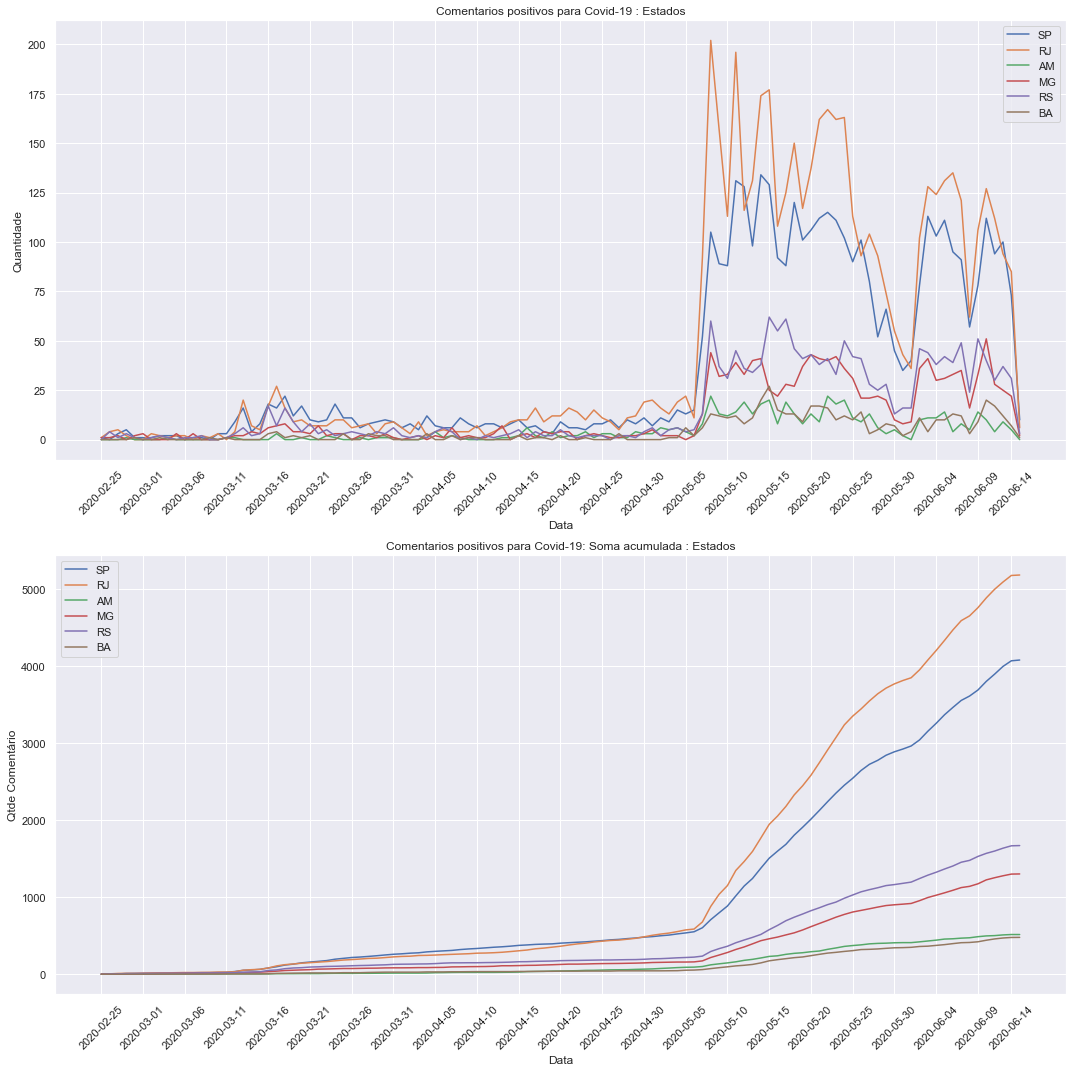

In [9]:
usr = users_.copy()

estados = ["SP", "RJ", "AM", "MG", "RS", "BA"]
list_df = []
for estado in estados:
    usr_ = usr[usr["state"] == estado]
    df_dt_ = hashtags_[
        (hashtags_['username'].isin(usr_['username'])) & (hashtags_['classify'] == 'positivo')
    ].drop_duplicates("username").copy()
    df_dt_['date'] = df_dt_['timestamp'].map(lambda x: datetime.strptime(x.strftime('%Y-%m-%d'), '%Y-%m-%d'))
    df_dt_['count'] = 1
    df_dt_ = df_dt_.groupby([df_dt_['date'].dt.date]).sum().reset_index()
    df_dt_ = df_dt_[df_dt_['date'] > pd.Timestamp(2020, 1, 1)]
    list_df.append(df_dt_)

df_merged = []
for idx, row in covid_data.iterrows():
    dt_search, list_cnt = row["date"], []
    for df_search in list_df:
        val_ = 0
        found_ = df_search[df_search["date"] == dt_search]
        if len(found_) > 0:
            val_ = int(found_["count"])
        list_cnt.append(val_)
    df_merged.append([dt_search] + list_cnt)
df_merged = pd.DataFrame(df_merged, columns=["date"] + estados)


datas = df_merged["date"].to_numpy()
tempo = np.arange(1, len(datas) + 1)
numero_tempo = list(np.arange(1, len(datas), steps))
numero_tempo = numero_tempo + [max(numero_tempo) + (steps - 1)]
data_tempo = list(datas[::steps]) + [datas[-1]]

steps = 5
plt.figure(figsize=(15, 15))
plt.subplot(2, 1, 1)
plt.title("Comentarios positivos para Covid-19 : Estados")
for estado in estados:
    cnt_ = df_merged[estado]
    plt.plot(tempo, cnt_, label=estado)
plt.xticks(numero_tempo, data_tempo, rotation=45)
plt.xlabel("Data")
plt.ylabel("Quantidade")
plt.legend()
plt.subplot(2, 1, 2)
plt.title("Comentarios positivos para Covid-19: Soma acumulada : Estados")
for estado in estados:
    cnt_ = df_merged[estado]
    cumsum_ = np.cumsum(cnt_)
    plt.plot(tempo, cumsum_, label=estado)
plt.xticks(numero_tempo, data_tempo, rotation=45)
plt.xlabel("Data")
plt.ylabel("Qtde Comentário")
plt.legend()
plt.tight_layout()
plt.show()

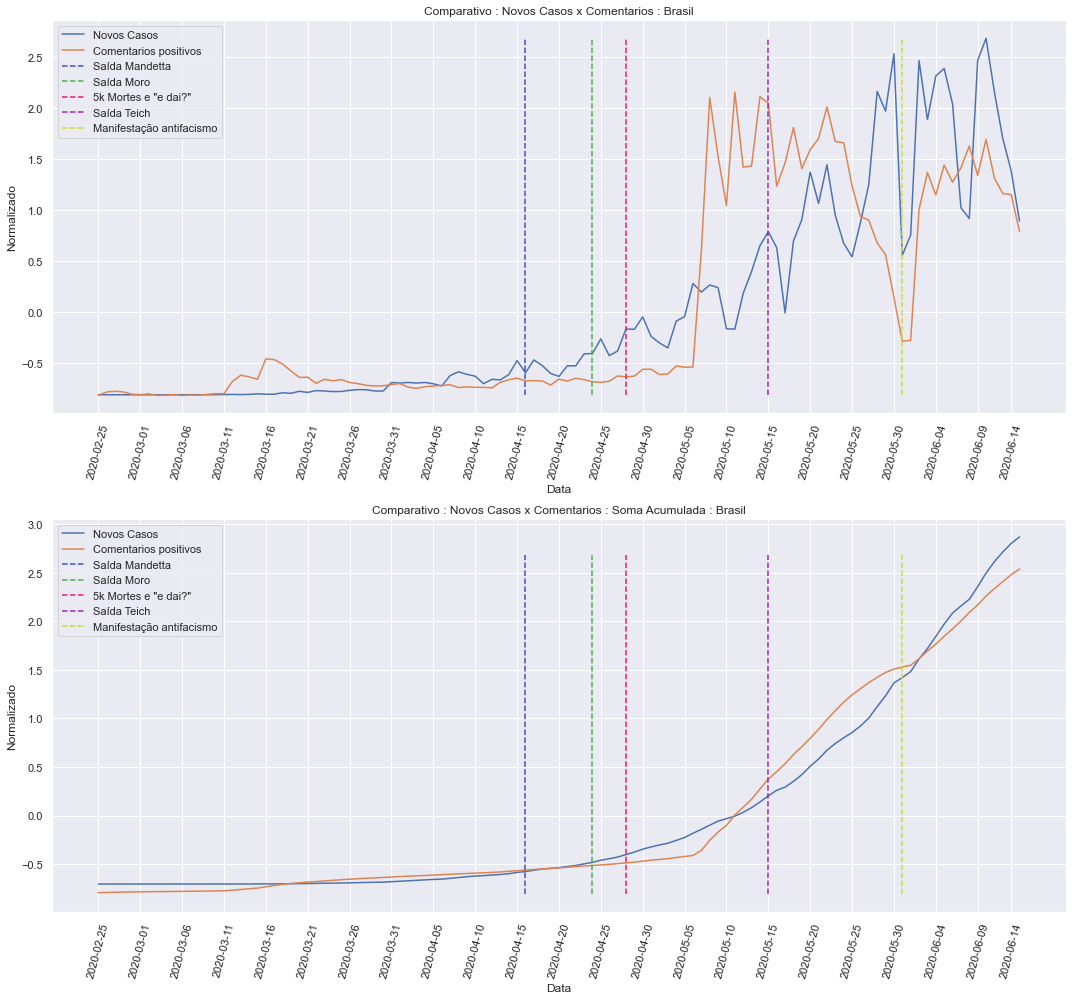

In [33]:
df_dt = hashtags_[hashtags_['classify'] == 'positivo'].drop_duplicates("username").copy()
df_dt['date'] = df_dt['timestamp'].map(lambda x: datetime.strptime(x.strftime('%Y-%m-%d'), '%Y-%m-%d'))
df_dt['count'] = 1
df_dt = df_dt.groupby([df_dt['date'].dt.date]).sum().reset_index()
df_dt = df_dt[df_dt['date'] > pd.Timestamp(2020, 1, 1)]

df_merged = []
for idx, row in covid_data.iterrows():
    dt_search = row["date"]
    found = df_dt[df_dt["date"] == dt_search]
    if len(found) > 0:
        df_merged.append(list(row.to_numpy()) + [int(found["count"])])
df_merged = pd.DataFrame(df_merged, columns=["date", "newCases", "newDeaths", "numComments"])

datas = df_merged["date"].to_numpy()

tempo = np.arange(1, len(datas) + 1)
numero_tempo = list(np.arange(1, len(datas), steps))
numero_tempo = numero_tempo + [max(numero_tempo) + (steps - 1)]
data_tempo = list(datas[::steps]) + [datas[-1]]

calc_novos_casos = df_merged["newCases"] / 212_000_000
calc_numero_comments = (df_merged["numComments"] * 0.75) / 8_280_000
novos_casos = scale(calc_novos_casos)
numero_comments = scale(calc_numero_comments)
cumsum_novos_casos = scale(np.cumsum(calc_novos_casos))
cumsum_numero_comments = scale(np.cumsum(calc_numero_comments))

idx_saida_mandetta = np.where(datas == date(2020, 4, 16))[0][0] + 1
idx_saida_moro = np.where(datas == date(2020, 4, 24))[0][0] + 1
idx_5000 = np.where(datas == date(2020, 4, 28))[0][0] + 1
idx_saida_teich = np.where(datas == date(2020, 5, 15))[0][0] + 1
idx_manifestacao = np.where(datas == date(2020, 5, 31))[0][0] + 1
mmin, mmax = np.min(novos_casos), np.max(novos_casos)

plt.figure(figsize=(15, 14))
plt.subplot(2, 1, 1)
plt.title("Comparativo : Novos Casos x Comentarios : Brasil")
plt.plot(tempo, novos_casos, label="Novos Casos")
plt.plot(tempo, numero_comments, label="Comentarios positivos")
plt.plot([idx_saida_mandetta, idx_saida_mandetta], [mmin, mmax], "--", c="#3f51b5", label="Saída Mandetta")
plt.plot([idx_saida_moro, idx_saida_moro], [mmin, mmax], "--", c="#4caf50", label="Saída Moro")
plt.plot([idx_5000, idx_5000], [mmin, mmax], "--", c="#e91e63", label="5k Mortes e \"e dai?\" ")
plt.plot([idx_saida_teich, idx_saida_teich], [mmin, mmax], "--", c="#9c27b0", label="Saída Teich")
plt.plot([idx_manifestacao, idx_manifestacao], [mmin, mmax], "--", c="#cddc39", label="Manifestação antifacismo")
plt.xticks(numero_tempo, data_tempo, rotation=75)
plt.xlabel("Data")
plt.ylabel("Normalizado")
plt.legend()
plt.subplot(2, 1, 2)
plt.title("Comparativo : Novos Casos x Comentarios : Soma Acumulada : Brasil")
plt.plot(tempo, cumsum_novos_casos, label="Novos Casos")
plt.plot(tempo, cumsum_numero_comments, label="Comentarios positivos")
plt.plot([idx_saida_mandetta, idx_saida_mandetta], [mmin, mmax], "--", c="#3f51b5", label="Saída Mandetta")
plt.plot([idx_saida_moro, idx_saida_moro], [mmin, mmax], "--", c="#4caf50", label="Saída Moro")
plt.plot([idx_5000, idx_5000], [mmin, mmax], "--", c="#e91e63", label="5k Mortes e \"e dai?\" ")
plt.plot([idx_saida_teich, idx_saida_teich], [mmin, mmax], "--", c="#9c27b0", label="Saída Teich")
plt.plot([idx_manifestacao, idx_manifestacao], [mmin, mmax], "--", c="#cddc39", label="Manifestação antifacismo")
plt.xticks(numero_tempo, data_tempo, rotation=75)
plt.xlabel("Data")

plt.ylabel("Normalizado")
plt.legend()
plt.tight_layout()
plt.show()

In [18]:
# Cross-Correlation
# x = np.sin(np.linspace(0, 10)) # novos_casos.copy()
# y = np.sin(np.linspace(0, 100) + 5) # numero_comments.copy()
# ccorr = ccf(x, y)
# lag = np.argmax(ccorr)
# print(ccorr)
# print(lag)
# c = np.roll(x, shift=int(np.ceil(lag)))
# plt.plot(c, label="c")
# plt.plot(x, label="x")
# plt.plot(y, label="y")
# plt.legend()

# grangercausalitytests(np.c_[x, y], maxlag=10)

result = adfuller(novos_casos)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

result = adfuller(numero_comments)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))    
    
# print(adfuller(numero_comments)[1])
# print(adfuller(novos_casos)[1])
# grangercausalitytests(np.c_[numero_comments, novos_casos], maxlag=15)

# calc_novos_casos = df_merged["newCases"] / 212_000_000
# calc_numero_comments = (df_merged["numComments"] * 0.75) / 8_280_000

# grangercausalitytests(np.c_[calc_numero_comments, calc_novos_casos], maxlag=15)

ADF Statistic: 0.397990
p-value: 0.981420
Critical Values:
	1%: -3.496
	5%: -2.890
	10%: -2.582
ADF Statistic: -1.638714
p-value: 0.462933
Critical Values:
	1%: -3.493
	5%: -2.889
	10%: -2.581


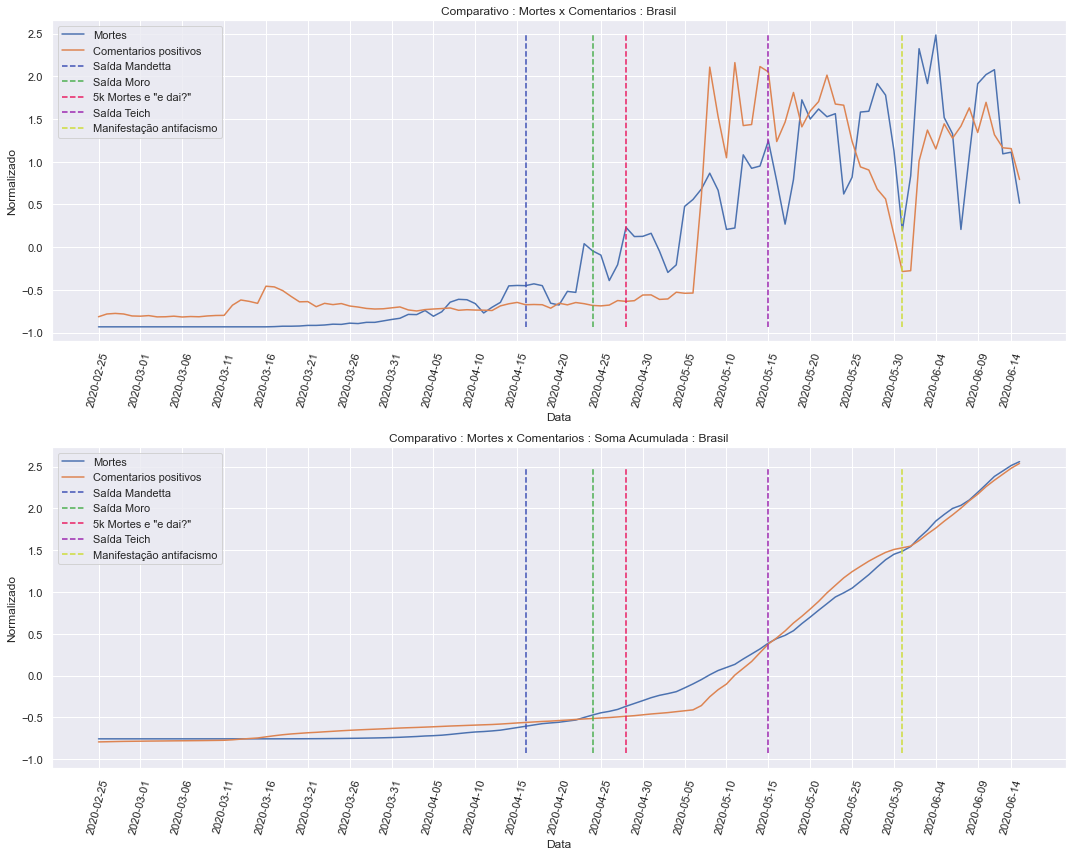

In [34]:
df_dt = hashtags_[hashtags_['classify'] == 'positivo'].drop_duplicates("username").copy()
df_dt['date'] = df_dt['timestamp'].map(lambda x: datetime.strptime(x.strftime('%Y-%m-%d'), '%Y-%m-%d'))
df_dt['count'] = 1
df_dt = df_dt.groupby([df_dt['date'].dt.date]).sum().reset_index()
df_dt = df_dt[df_dt['date'] > pd.Timestamp(2020, 1, 1)]

df_merged = []
for idx, row in covid_data.iterrows():
    dt_search = row["date"]
    found = df_dt[df_dt["date"] == dt_search]
    if len(found) > 0:
        df_merged.append(list(row.to_numpy()) + [int(found["count"])])
df_merged = pd.DataFrame(df_merged, columns=["date", "newCases", "newDeaths", "numComments"])

datas = df_merged["date"].to_numpy()
tempo = np.arange(1, len(datas) + 1)
numero_tempo = list(np.arange(1, len(datas), steps))
numero_tempo = numero_tempo + [max(numero_tempo) + (steps - 1)]
data_tempo = list(datas[::steps]) + [datas[-1]]

calc_novos_casos = df_merged["newDeaths"] / 212_000_000
calc_numero_comments = (df_merged["numComments"] * 0.75) / 8_280_000
novos_casos = scale(calc_novos_casos)
numero_comments = scale(calc_numero_comments)
# novos_casos = df_merged["newCases"]
# numero_comments = (df_merged["numComments"] * 0.75)
cumsum_novos_casos = scale(np.cumsum(calc_novos_casos))
cumsum_numero_comments = scale(np.cumsum(calc_numero_comments))

idx_saida_mandetta = np.where(datas == date(2020, 4, 16))[0][0] + 1
idx_saida_moro = np.where(datas == date(2020, 4, 24))[0][0] + 1
idx_5000 = np.where(datas == date(2020, 4, 28))[0][0] + 1
idx_saida_teich = np.where(datas == date(2020, 5, 15))[0][0] + 1
idx_manifestacao = np.where(datas == date(2020, 5, 31))[0][0] + 1
mmin, mmax = np.min(novos_casos), np.max(novos_casos)

plt.figure(figsize=(15, 12))
plt.subplot(2, 1, 1)
plt.title("Comparativo : Mortes x Comentarios : Brasil")
plt.plot(tempo, novos_casos, label="Mortes")
plt.plot(tempo, numero_comments, label="Comentarios positivos")
plt.plot([idx_saida_mandetta, idx_saida_mandetta], [mmin, mmax], "--", c="#3f51b5", label="Saída Mandetta")
plt.plot([idx_saida_moro, idx_saida_moro], [mmin, mmax], "--", c="#4caf50", label="Saída Moro")
plt.plot([idx_5000, idx_5000], [mmin, mmax], "--", c="#e91e63", label="5k Mortes e \"e dai?\" ")
plt.plot([idx_saida_teich, idx_saida_teich], [mmin, mmax], "--", c="#9c27b0", label="Saída Teich")
plt.plot([idx_manifestacao, idx_manifestacao], [mmin, mmax], "--", c="#cddc39", label="Manifestação antifacismo")
plt.xticks(numero_tempo, data_tempo, rotation=75)
plt.xlabel("Data")
plt.ylabel("Normalizado")
plt.legend()
plt.subplot(2, 1, 2)
plt.title("Comparativo : Mortes x Comentarios : Soma Acumulada : Brasil")
plt.plot(tempo, cumsum_novos_casos, label="Mortes")
plt.plot(tempo, cumsum_numero_comments, label="Comentarios positivos")
plt.plot([idx_saida_mandetta, idx_saida_mandetta], [mmin, mmax], "--", c="#3f51b5", label="Saída Mandetta")
plt.plot([idx_saida_moro, idx_saida_moro], [mmin, mmax], "--", c="#4caf50", label="Saída Moro")
plt.plot([idx_5000, idx_5000], [mmin, mmax], "--", c="#e91e63", label="5k Mortes e \"e dai?\" ")
plt.plot([idx_saida_teich, idx_saida_teich], [mmin, mmax], "--", c="#9c27b0", label="Saída Teich")
plt.plot([idx_manifestacao, idx_manifestacao], [mmin, mmax], "--", c="#cddc39", label="Manifestação antifacismo")
plt.xticks(numero_tempo, data_tempo, rotation=75)
plt.xlabel("Data")
plt.ylabel("Normalizado")
plt.legend()
plt.tight_layout()
plt.show()